In [5]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt

figsize = (10, 10)

In [ ]:
# для Colab
!rm -r sample_data

## 1. Определение количества карточек на изображении

**А) Карточки изолированные**

**Б) Карточки накладываются друг на друга**

## 2. Определение фигуры на карточке

**А) Определение типа фигуры - многоугольник или фигура с гладкой границей**

**Б) Для многоугольников определить количество вершин**

**В) Определить, является ли многоугольник выпуклым**

In [27]:
def print_img(img):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

    
def approx_contour(contours, alpha=0.02, max_card_side=164, thresh_area=10000, no_area=False,
                   use_overlay=False, use_smooth=False):
    max_card_side_standard = 164

    approxes = []
    more_approxes = []
    for cnt in contours:
        perimeter = cv.arcLength(cnt, True)
        beta = max_card_side / max_card_side_standard
        epsilon = alpha * beta * perimeter
        approx = cv.approxPolyDP(cnt, epsilon, True)
        more_approx = cv.approxPolyDP(cnt, 0.005, True)
        area = cv.contourArea(approx)
        if no_area or (area > thresh_area):
            approxes.append(approx)
            more_approxes.append(more_approx)

    flag = False

    # для различия карточек при наложении
    if use_overlay:
        for approx in approxes:
            if len(approx) > 4:
                print("Карточки перекрываются!")
                flag = True
                break

    # для более точной аппрокисмации гладких фигур
    if use_smooth:
        for idx in range(len(approxes)):
            dist = np.abs(cv.contourArea(approxes[idx]) - cv.contourArea(more_approxes[idx]))
            if (len(approxes[idx]) >= 6) and (dist >= 150):
                print("Найдена гладкая фигура!")
                flag = True
                break

    return approxes, flag


def mean_brightness(img, mask):
    h, w = img.shape[:2]
    sum_bright = 0
    sum_pixels = 0
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 255:
                sum_bright += img[i, j]
                sum_pixels += 1

    mean_bright = sum_bright / sum_pixels
    return mean_bright


def change_brightness(img, mask):
    h, w = img.shape[:2]
    mean_bright = mean_brightness(img, mask)
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 255:
                img[i, j] = (img[i, j] / mean_bright) * 65

    return img

In [32]:
def OiR(im_name):
    im = cv.imread(im_name)
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

    canny = cv.Canny(imgray, 10, 70)
    kernel = np.ones((3, 3), np.uint8)
    dilate = cv.morphologyEx(canny, cv.MORPH_DILATE, kernel)

    contours, _ = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    im_dark = np.zeros(imgray.shape, np.uint8)
    im_dark = cv.drawContours(im_dark, contours, -1, (255, 255, 255), 2)

    fill = cv.fillPoly(im_dark, contours, (255, 255, 255), 8, 0)
    kernel = np.ones((7, 7), np.uint8)
    erode = cv.morphologyEx(fill, cv.MORPH_ERODE, kernel)

    contours, _ = cv.findContours(erode, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    main_approxes, flag_overlay = approx_contour(contours, alpha=0.02, thresh_area=10000, use_overlay=True)
    if flag_overlay:
        # есть пересечения карточек => считаем ещё раз, но более точно
        main_approxes, _ = approx_contour(contours, alpha=0.001, thresh_area=10000)
    max_card_side = None
    for idx in range(len(main_approxes)):
        idx_approx, _ = approx_contour([main_approxes[idx]], alpha=0.05, no_area=True)
        if len(idx_approx[0]) == 4:
            p1, p2, p3, p4 = idx_approx[0]
            list_len = [cv.norm(p1 - p2), cv.norm(p2 - p3), cv.norm(p3 - p4), cv.norm(p1 - p4)]
            max_card_side = max(list_len)
            break

    im_vis = im.copy()
    for idx in range(len(main_approxes)):
        mask = np.zeros_like(imgray)
        cv.drawContours(mask, main_approxes, idx, (255, 255, 255), cv.FILLED)
        out = np.zeros_like(imgray)
        out[mask == 255] = imgray[mask == 255]

        out_new = change_brightness(out, mask)

        _, thresh = cv.threshold(out_new, 90, 255, cv.THRESH_BINARY)
        kernel = np.ones((3, 3), np.uint8)
        dilate = cv.morphologyEx(thresh, cv.MORPH_DILATE, kernel)

        contours, _ = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        approxes, _ = approx_contour(contours, alpha=0.001, no_area=True, max_card_side=max_card_side)
        fill = cv.fillPoly(thresh, approxes, (255, 255, 255), 8, 0)

        contours, _ = cv.findContours(fill, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        approxes, flag_smooth = approx_contour(contours, alpha=0.02, thresh_area=1600, use_smooth=True,
                                               max_card_side=max_card_side)
        if flag_smooth and not flag_overlay:
            # встречен гладкий конутр => аппроксимировать с большей точностью
            approxes, _ = approx_contour(contours, alpha=0.001, thresh_area=1600, max_card_side=max_card_side)
        cv.drawContours(im_vis, approxes, -1, (0, 255, 0), 3)

        font = cv.FONT_HERSHEY_SIMPLEX
        for approx in approxes:
            M = cv.moments(approx)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            text = f"P{len(approx)}"
            if cv.isContourConvex(approx):
                text += 'C'
            if len(approx) > 75:
                text = 'S'
            cv.putText(im_vis, text, (cx, cy - 45), font, 1.15, (255, 255, 255), 2, cv.LINE_AA)

    im_vis = cv.cvtColor(im_vis, cv.COLOR_BGR2RGB)
    print_img(im_vis)

**Общий случай**

Найдена гладкая фигура!
Найдена гладкая фигура!
Найдена гладкая фигура!


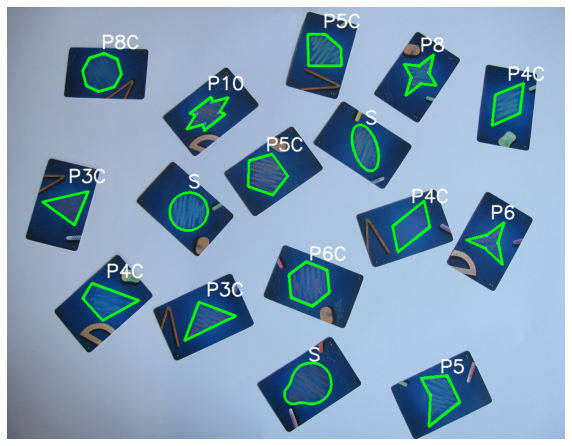

In [33]:
OiR("Образцы/IMG_1.jpg")

Карточки перекрываются!
Найдена гладкая фигура!
Найдена гладкая фигура!
Найдена гладкая фигура!


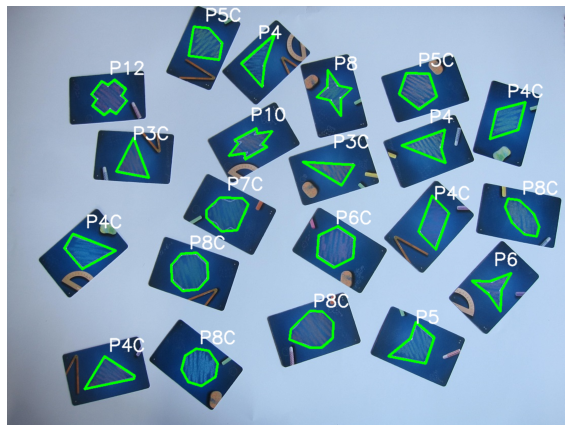

In [34]:
OiR("Образцы/IMG_2.jpg")

Карточки перекрываются!
Найдена гладкая фигура!
Найдена гладкая фигура!
Найдена гладкая фигура!


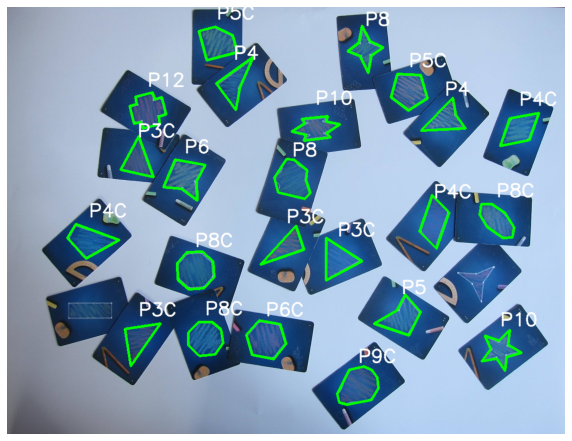

In [35]:
OiR("Образцы/IMG_4.jpg")

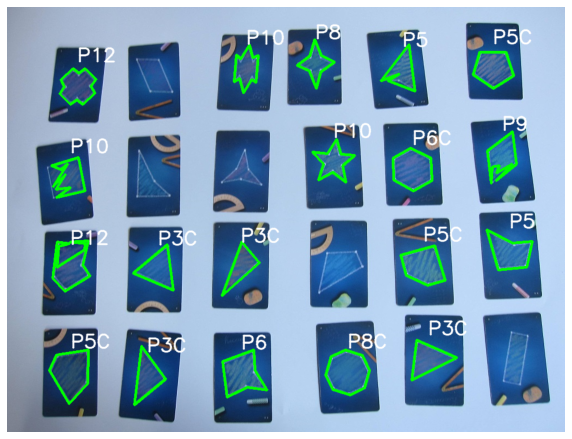

In [13]:
OiR("Образцы/IMG_6.jpg")

Найдена гладкая фигура!
Найдена гладкая фигура!
Найдена гладкая фигура!
Найдена гладкая фигура!


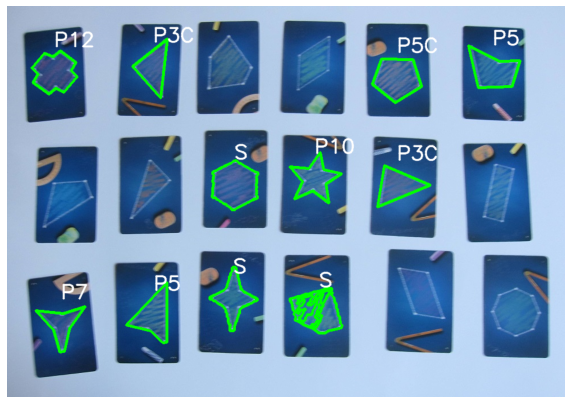

In [14]:
OiR("Образцы/IMG_7.jpg")

**Частный случай**

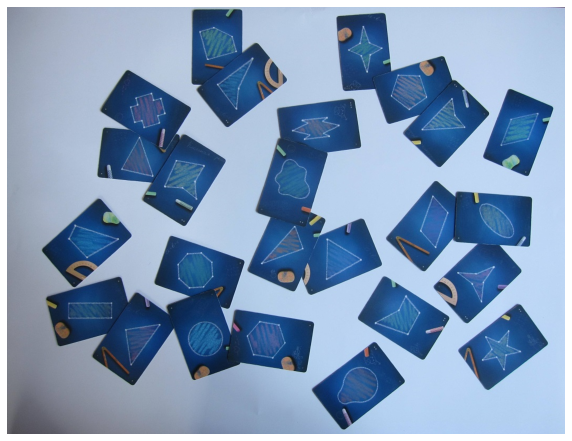

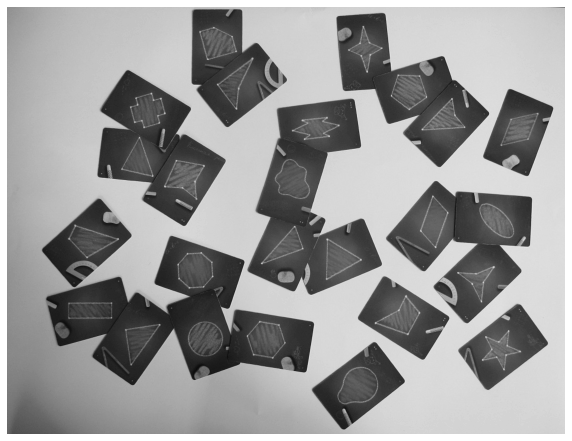

In [11]:
im = cv.imread('Образцы/IMG_4.jpg')

im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
print_img(im_rgb)

imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
print_img(imgray)

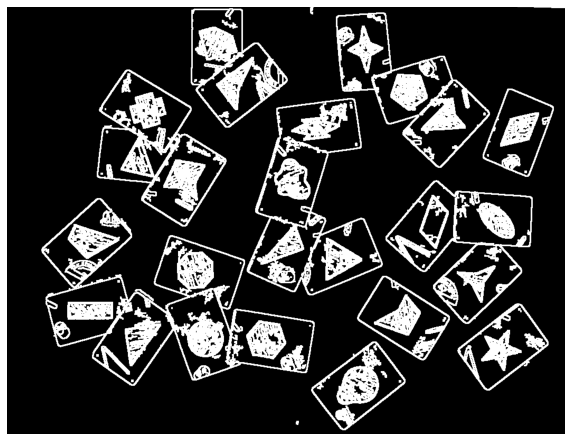

In [12]:
kernel = np.ones((3, 3), np.uint8)
canny = cv.Canny(imgray, 10, 70)
dilate = cv.morphologyEx(canny, cv.MORPH_DILATE, kernel)
print_img(dilate)

Кол-во внешних контуров до эрозии: 13


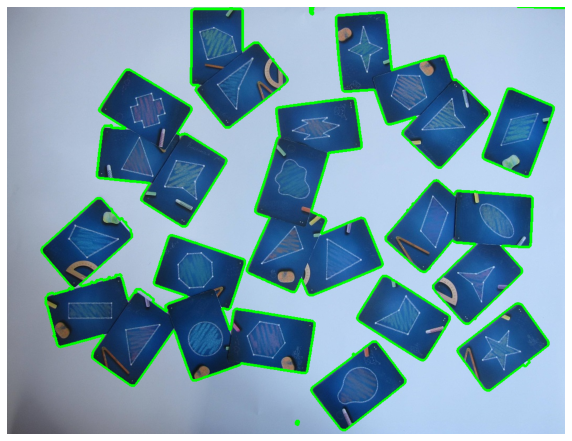

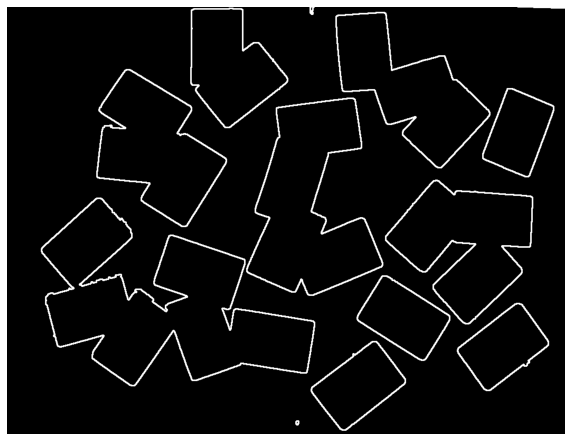

In [13]:
contours, _ = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("Кол-во внешних контуров до эрозии:", len(contours))

im_drow = cv.drawContours(im.copy(), contours, -1, (0, 255, 0), 3)
im_drow = cv.cvtColor(im_drow, cv.COLOR_BGR2RGB)
print_img(im_drow)

im_dark = np.zeros(imgray.shape, np.uint8)
im_dark = cv.drawContours(im_dark, contours, -1, (255, 255, 255), 2)
print_img(im_dark)

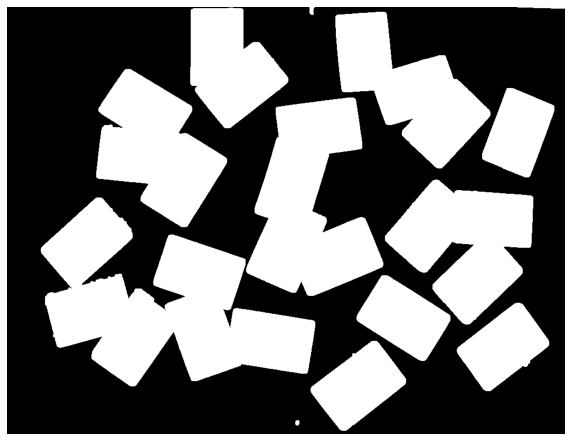

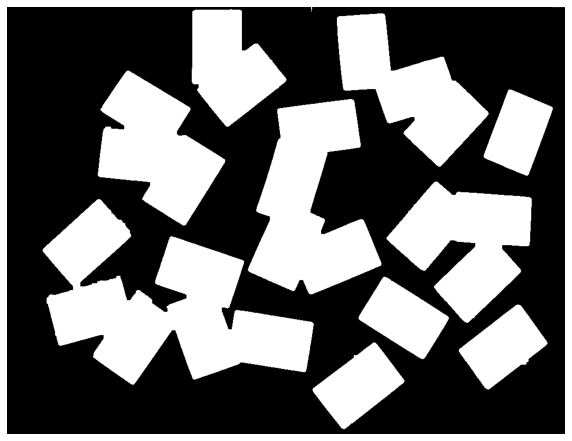

In [14]:
fill = cv.fillPoly(im_dark.copy(), contours, (255, 255, 255), 8, 0)
print_img(fill)

kernel = np.ones((7, 7), np.uint8)
erode = cv.morphologyEx(fill, cv.MORPH_ERODE, kernel)
print_img(erode)

Кол-во внешних контуров после эрозии: 12


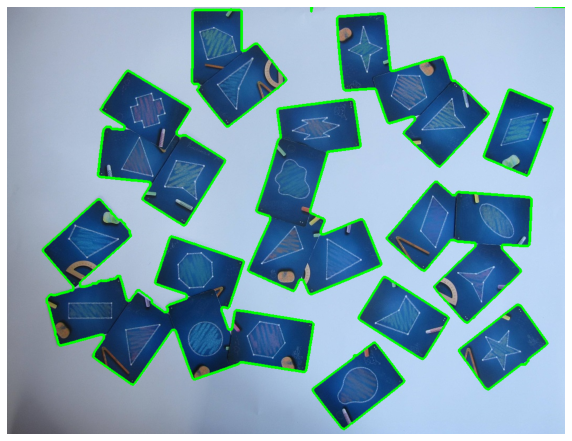

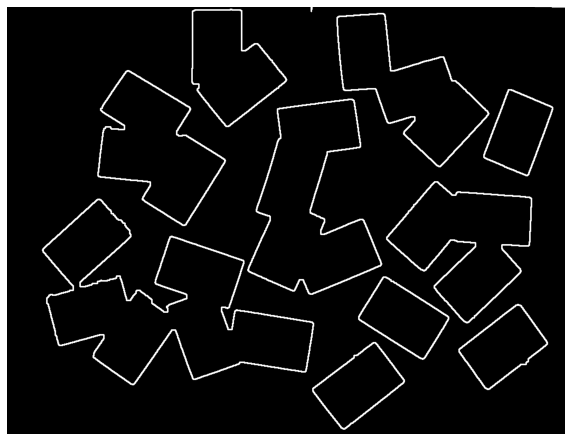

In [15]:
main_contours, _ = cv.findContours(erode, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("Кол-во внешних контуров после эрозии:", len(main_contours))

im_drow = cv.drawContours(im.copy(), main_contours, -1, (0, 255, 0), 3)
im_drow = cv.cvtColor(im_drow, cv.COLOR_BGR2RGB)
print_img(im_drow)

im_dark = np.zeros(imgray.shape, np.uint8)
im_dark = cv.drawContours(im_dark, main_contours, -1, (255, 255, 255), 2)
print_img(im_dark)

Карточки перекрываются!


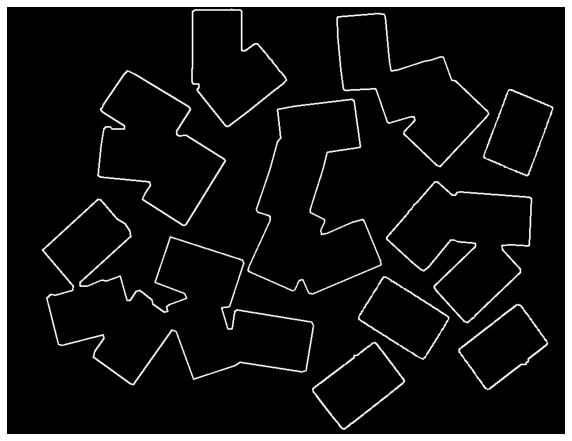

In [16]:
main_approxes, flag_overlay = approx_contour(main_contours, alpha=0.02, thresh_area=10000, use_overlay=True)
if flag_overlay:
    # считаем ещё раз, но более точно
    main_approxes, _ = approx_contour(main_contours, alpha=0.001, thresh_area=10000)

im_dark = np.zeros(imgray.shape, np.uint8)
im_dark = cv.drawContours(im_dark, main_approxes, -1, (255, 255, 255), 2)
print_img(im_dark)

In [17]:
max_card_side = None

for idx in range(len(main_approxes)):
        idx_approx, _ = approx_contour([main_approxes[idx]], alpha=0.05, thresh_area=10000)
        if len(idx_approx[0]) == 4:
            p1 = idx_approx[0][0]
            p2 = idx_approx[0][1]
            p3 = idx_approx[0][2]
            p4 = idx_approx[0][3]
            list_len = [cv.norm(p1 - p2), cv.norm(p2 - p3), cv.norm(p3 - p4), cv.norm(p1 - p4)]
            max_card_side = max(list_len)
            break

max_card_side

146.60491124106312

56.879286201572654
64.43161825428172


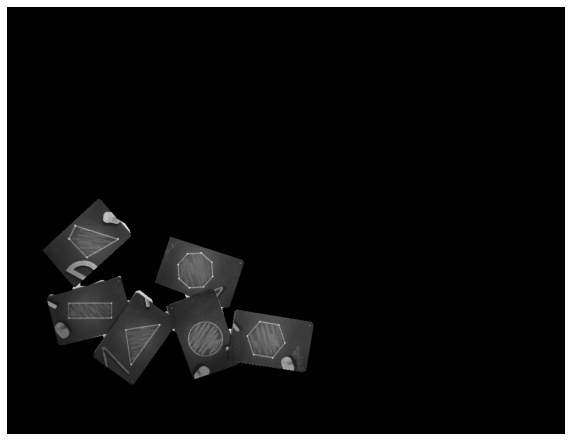

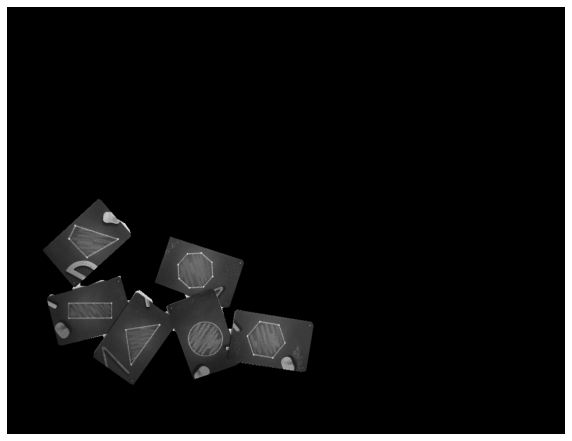

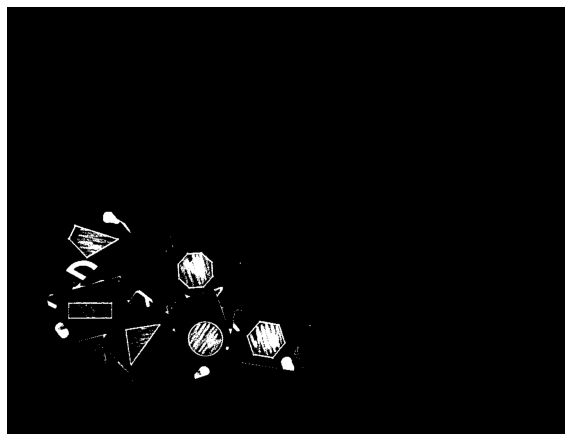

In [18]:
mask = np.zeros_like(imgray)
cv.drawContours(mask, main_approxes, 3, (255, 255, 255), cv.FILLED)
out = np.zeros_like(imgray)
out[mask == 255] = imgray[mask == 255]
print(mean_brightness(out, mask))
out_new = change_brightness(out.copy(), mask)
print(mean_brightness(out_new, mask))
print_img(out_new)
_, thresh = cv.threshold(out_new, 87, 255, cv.THRESH_BINARY) ### 90
print_img(out)
print_img(thresh)

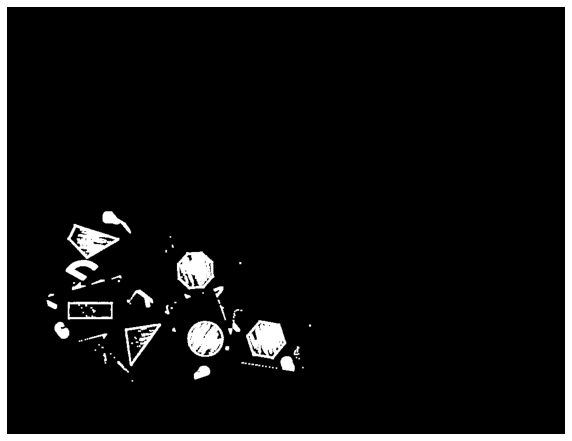

In [19]:
kernel = np.ones((3, 3), np.uint8)
dilate = cv.morphologyEx(thresh, cv.MORPH_DILATE, kernel)
print_img(dilate)

Кол-во внешних контуров: 67


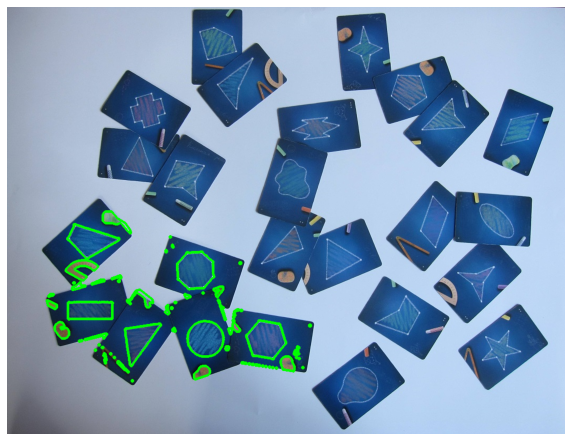

In [20]:
contours, _ = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("Кол-во внешних контуров:", len(contours))
im_test = cv.drawContours(im.copy(), contours, -1, (0, 255, 0), 3)
im_test = cv.cvtColor(im_test, cv.COLOR_BGR2RGB)
print_img(im_test)

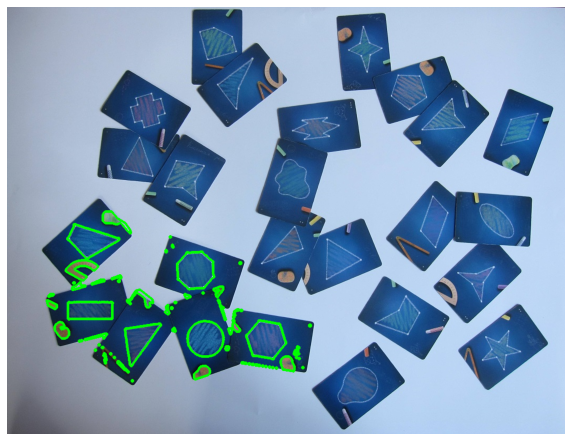

In [21]:
approxes, _ = approx_contour(contours, alpha=0.001, no_area=True, max_card_side=max_card_side)
im_drow = cv.drawContours(im.copy(), approxes, -1, (0, 255, 0), 3)
im_drow = cv.cvtColor(im_drow, cv.COLOR_BGR2RGB)
print_img(im_drow)

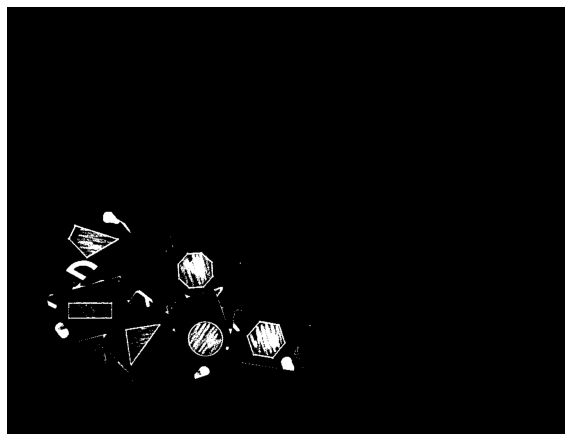

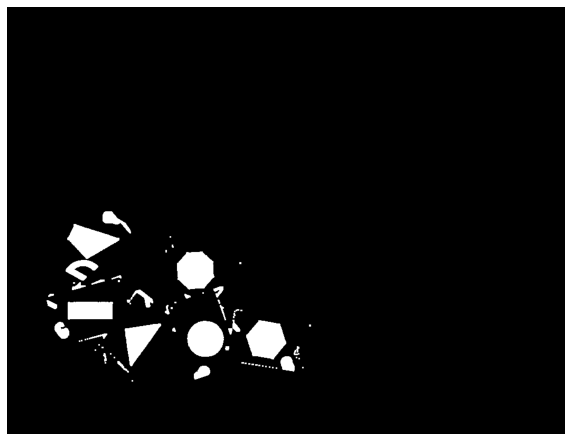

In [22]:
fill_test = cv.fillPoly(thresh.copy(), approxes, (255, 255, 255), 8, 0)
print_img(thresh)
print_img(fill_test)

Кол-во внешних контуров: 67


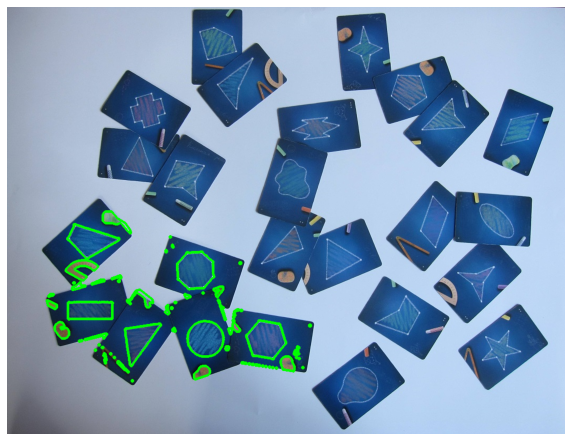

In [23]:
contours, _ = cv.findContours(fill_test, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("Кол-во внешних контуров:", len(contours))
im_drow = cv.drawContours(im.copy(), contours, -1, (0, 255, 0), 3)
im_drow = cv.cvtColor(im_drow, cv.COLOR_BGR2RGB)
print_img(im_drow)

Найдена гладкая фигура!
до [3, 8, 6, 4, 8, 4]
после [3, 8, 6, 4, 8, 4]


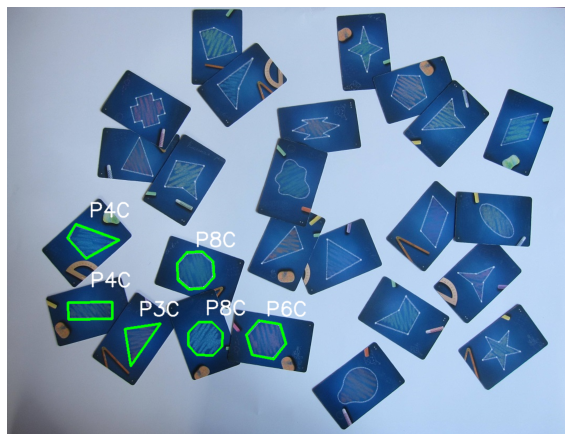

In [26]:
approxes, flag_smooth = approx_contour(contours, alpha=0.025, thresh_area=1600, use_smooth=True, max_card_side=max_card_side)
print("до", [len(x) for x in approxes])
if flag_smooth and not flag_overlay:
    approxes, _ = approx_contour(contours, alpha=0.001, thresh_area=1600)
print("после", [len(x) for x in approxes])

im_drow = cv.drawContours(im.copy(), approxes, -1, (0, 255, 0), 3)

font = cv.FONT_HERSHEY_SIMPLEX
for approx in approxes:
    M = cv.moments(approx)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    text = f"P{len(approx)}"
    if cv.isContourConvex(approx):
        text += 'C'
    cv.putText(im_drow, text, (cx, cy - 45), font, 1.25, (255, 255, 255), 2, cv.LINE_AA)

im_drow = cv.cvtColor(im_drow, cv.COLOR_BGR2RGB)
print_img(im_drow)